**MUHAMMAD FAHMI**

**FRESH GRADUATE ACADEMY**

**MACHINE LEARNING - IBM**

**No. Registrasi : 0182180131-64**

**FINAL SUBMISSION : IMAGE CLASSIFICATION MODEL DEPLOYMENT**

# **Import Data yang digunakan**

In [1]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadfahmi26","key":"e52aa45cb22e0facc8b4a2863055590c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d brsdincer/vehicle-detection-image-set

 94% 112M/119M [00:00<00:00, 127MB/s] 
100% 119M/119M [00:00<00:00, 128MB/s]


In [6]:
!ls

kaggle.json  sample_data  vehicle-detection-image-set.zip


# **Import Library**

In [89]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from glob import glob
from keras.models import Sequential
from keras.layers import MaxPool2D,Dense,Conv2D,Flatten,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,LearningRateScheduler
import warnings
from tqdm import tqdm
from PIL import Image
warnings.filterwarnings('ignore')

# **Preprocessing data**

In [90]:
maindir = "/content/data"
os.listdir(maindir)

['non-vehicles', 'vehicles']

In [91]:
nonvehicles_dir = "/content/data/non-vehicles"
vehicles_dir = "/content/data/vehicles"
non_vehicles = os.listdir(maindir+"/non-vehicles")
vehicles = os.listdir(maindir+"/vehicles")

print(f"Number of Vehicle Images: {len(vehicles)}")
print(f"Number of Non Vehicle Images: {len(non_vehicles)}")

Number of Vehicle Images: 8792
Number of Non Vehicle Images: 8968


**Visualisasi Data**

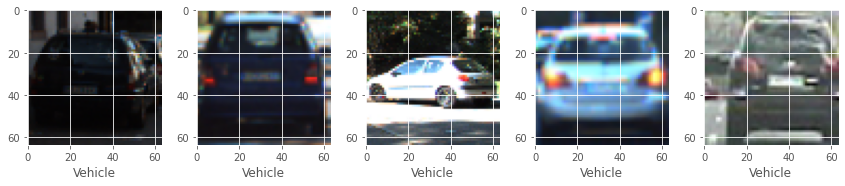

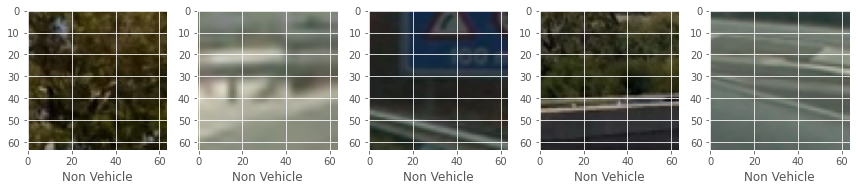

In [92]:
plt.figure(figsize=(12,9))
import cv2
vehicle_img = np.random.choice(vehicles,5)
nonvehicle_img = np.random.choice(non_vehicles,5)
for i in range(5):
    plt.subplot(1,5,i+1)
    img = cv2.imread(vehicles_dir+'/'+vehicle_img[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Vehicle")
    #plt.axis("off")
    plt.tight_layout()
    plt.imshow(img)
plt.show()
plt.figure(figsize=(12,9)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    img = cv2.imread(nonvehicles_dir+'/'+nonvehicle_img[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Non Vehicle")
    #plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

In [93]:
train = []
label = []
import tqdm
from tensorflow.keras.preprocessing import image

for i in tqdm.tqdm(vehicles):
    img = cv2.imread(vehicles_dir+'/'+ i)
    img = cv2.resize(img,(150,150))
    train.append(img)
    label.append("Vehicle")
    
for i in tqdm.tqdm(non_vehicles):
    img = cv2.imread(nonvehicles_dir+'/'+ i)
    img = cv2.resize(img,(150,150))
    train.append(img)
    label.append("Non Vehicle")

100%|██████████| 8968/8968 [00:02<00:00, 3503.67it/s]


In [94]:
train = np.array(train)
label = np.array(label)
train.shape,label.shape

((17760, 150, 150, 3), (17760,))

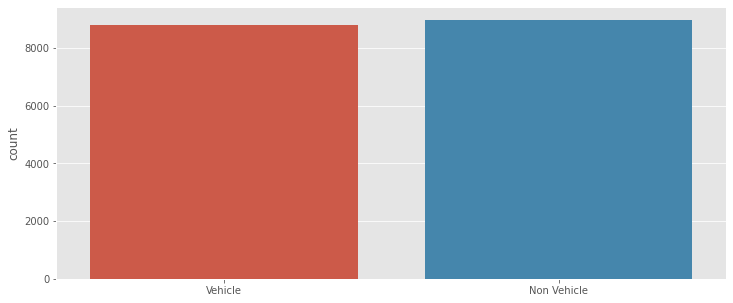

In [95]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(12,5))
sns.countplot(x = label)
plt.show()

In [96]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
le = LabelEncoder()
label= le.fit_transform(label)

In [82]:
label

array([1, 1, 1, ..., 0, 0, 0])

In [97]:
label = to_categorical(label)
print(label.shape)
train,label = shuffle(train, label)

(17760, 2)


**Pembagian data Training dan Testing**

In [98]:
x_train,x_test,y_train,y_test = train_test_split(train,label,test_size=0.2,random_state = 42)

In [118]:
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights = "imagenet",include_top = False,input_shape=(150,150,3))

**Pembuatan Model**

In [119]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout
model = effnet.output
model = Conv2D()(model)
model = MaxPooling2D()(model)
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2,activation='softmax')(model)

model = Model(inputs = effnet.input, outputs = model)

In [120]:
model.compile(optimizer ="adam", loss = "categorical_crossentropy",metrics = ['accuracy'])

In [123]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("vehicle.h5",monitor = "val_accuracy",save_best_only = True, 
                             mode='auto',verbose=1)
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 5,mode='auto',verbose=1)
reducelr = ReduceLROnPlateau(monitor = "val_accuracy",factor = 0.3, patience = 3,
                            min_delta = 0.0199,mode = 'auto',verbose=1)

In [124]:
history  = model.fit(x_train,y_train, epochs = 5,batch_size=32, validation_data = (x_test,y_test),
                    verbose = 1, callbacks = [checkpoint, earlystop,reducelr])

Epoch 1/5
444/444 [==============================] - 1533s 3s/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.0083 - val_accuracy: 0.9980

Epoch 00001: val_accuracy improved from -inf to 0.99803, saving model to vehicle.h5
Epoch 2/5
444/444 [==============================] - 1529s 3s/step - loss: 0.0068 - accuracy: 0.9974 - val_loss: 0.0198 - val_accuracy: 0.9952

Epoch 00002: val_accuracy did not improve from 0.99803
Epoch 3/5
444/444 [==============================] - 1531s 3s/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.0036 - val_accuracy: 0.9989

Epoch 00003: val_accuracy improved from 0.99803 to 0.99887, saving model to vehicle.h5
Epoch 4/5
444/444 [==============================] - 1533s 3s/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0050 - val_accuracy: 0.9989

Epoch 00004: val_accuracy did not improve from 0.99887

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/5
444/444 [==============================] - 1528s 3s/

**Evaluasi data**

In [125]:
model.evaluate(x_test,y_test)

111/111 [==============================] - 72s 648ms/step - loss: 0.0015 - accuracy: 0.9994


[0.001532218186184764, 0.9994369149208069]

In [126]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_pred[:15]

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [127]:
y_test = np.argmax(y_test,axis=1)
y_test[:15]

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [128]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1810
           1       1.00      1.00      1.00      1742

    accuracy                           1.00      3552
   macro avg       1.00      1.00      1.00      3552
weighted avg       1.00      1.00      1.00      3552



**Plot Akurasi dan Loss**

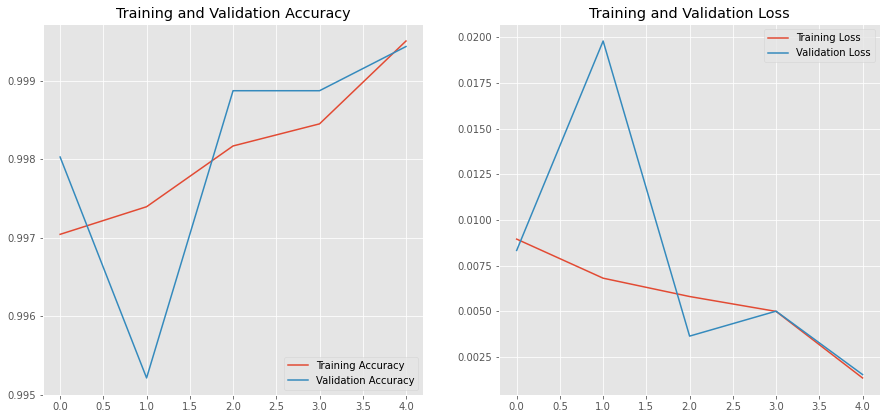

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Aktual vs Prediksi**

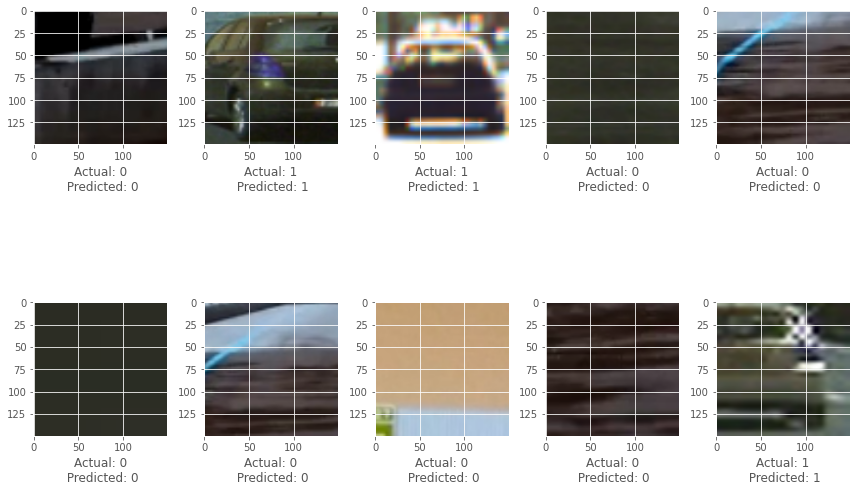

In [132]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = np.random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[sample_idx])
    plt.xlabel(f"Actual: {y_test[sample_idx]}\n Predicted: {y_pred[sample_idx]}")
    
plt.tight_layout()
plt.show()

# **Membuat Model TF-Lite**

In [134]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprs_h0l7v/assets


In [135]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)